In [2]:
import numpy as np
import torch
import gif
import matplotlib.pyplot as plt
import pytorch_lightning as pl 
from pathlib import Path
import yaml
import matplotlib.ticker as ticker
import matplotlib.colors as colors


from scipy.io import loadmat

from scipy.interpolate import LinearNDInterpolator as interp_lin

import seaborn

seaborn.set_style("darkgrid")

In [44]:
data_path = Path(r'/Users/kdoh/Library/CloudStorage/OneDrive-UCB-O365/Documents/Research/QuadConv/data/ignition_grid')

data_file = list(data_path.glob('*.npy'))[0]

dataset = np.float32(np.load(data_file))

dataset = dataset[:,:,1]

In [93]:
from numpy.linalg import svd

def calc_full_POD(dataset, rank=10):

    X = dataset.reshape(dataset.shape[0], -1).transpose(0,1)

    U,S,Vh = svd(X)

    processed_data = U[:,:rank] @ np.diag(S[:rank]) @ Vh[:rank, :]

    return processed_data


def calc_split_POD(dataset, rank=10):

    split = np.int(np.floor(0.8 * dataset.shape[0]))

    rng = np.random.default_rng(seed=1)

    sub_idx = rng.permutation(np.arange(dataset.shape[0]))

    subset = dataset[sub_idx[:split], :]

    X = subset.reshape(subset.shape[0], -1).transpose(0,1)

    U,S,Vh = svd(X)

    Xhat = dataset.reshape(dataset.shape[0], -1).T

    processed_data = Vh[:rank, :].T @ Vh[:rank, :] @ Xhat

    return processed_data.T



In [106]:
save_path = Path(r'/Users/kdoh/Library/CloudStorage/OneDrive-UCB-O365/Documents/Research/QuadConv/pod-example')

rank = 300

processed_data = calc_split_POD(dataset, rank=rank)

difference_norm = np.sqrt((dataset - processed_data)**2)

relative_difference_norm = difference_norm / np.sqrt((dataset)**2)

/var/folders/f7/6vsl4czs4vb98bnrjvfqxdcc0000gn/T/ipykernel_31202/3664563865.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split = np.int(np.floor(0.8 * dataset.shape[0]))
/var/folders/f7/6vsl4czs4vb98bnrjvfqxdcc0000gn/T/ipykernel_31202/3304222277.py:9: RuntimeWarning: divide by zero encountered in divide
  relative_difference_norm = difference_norm / np.sqrt((dataset)**2)


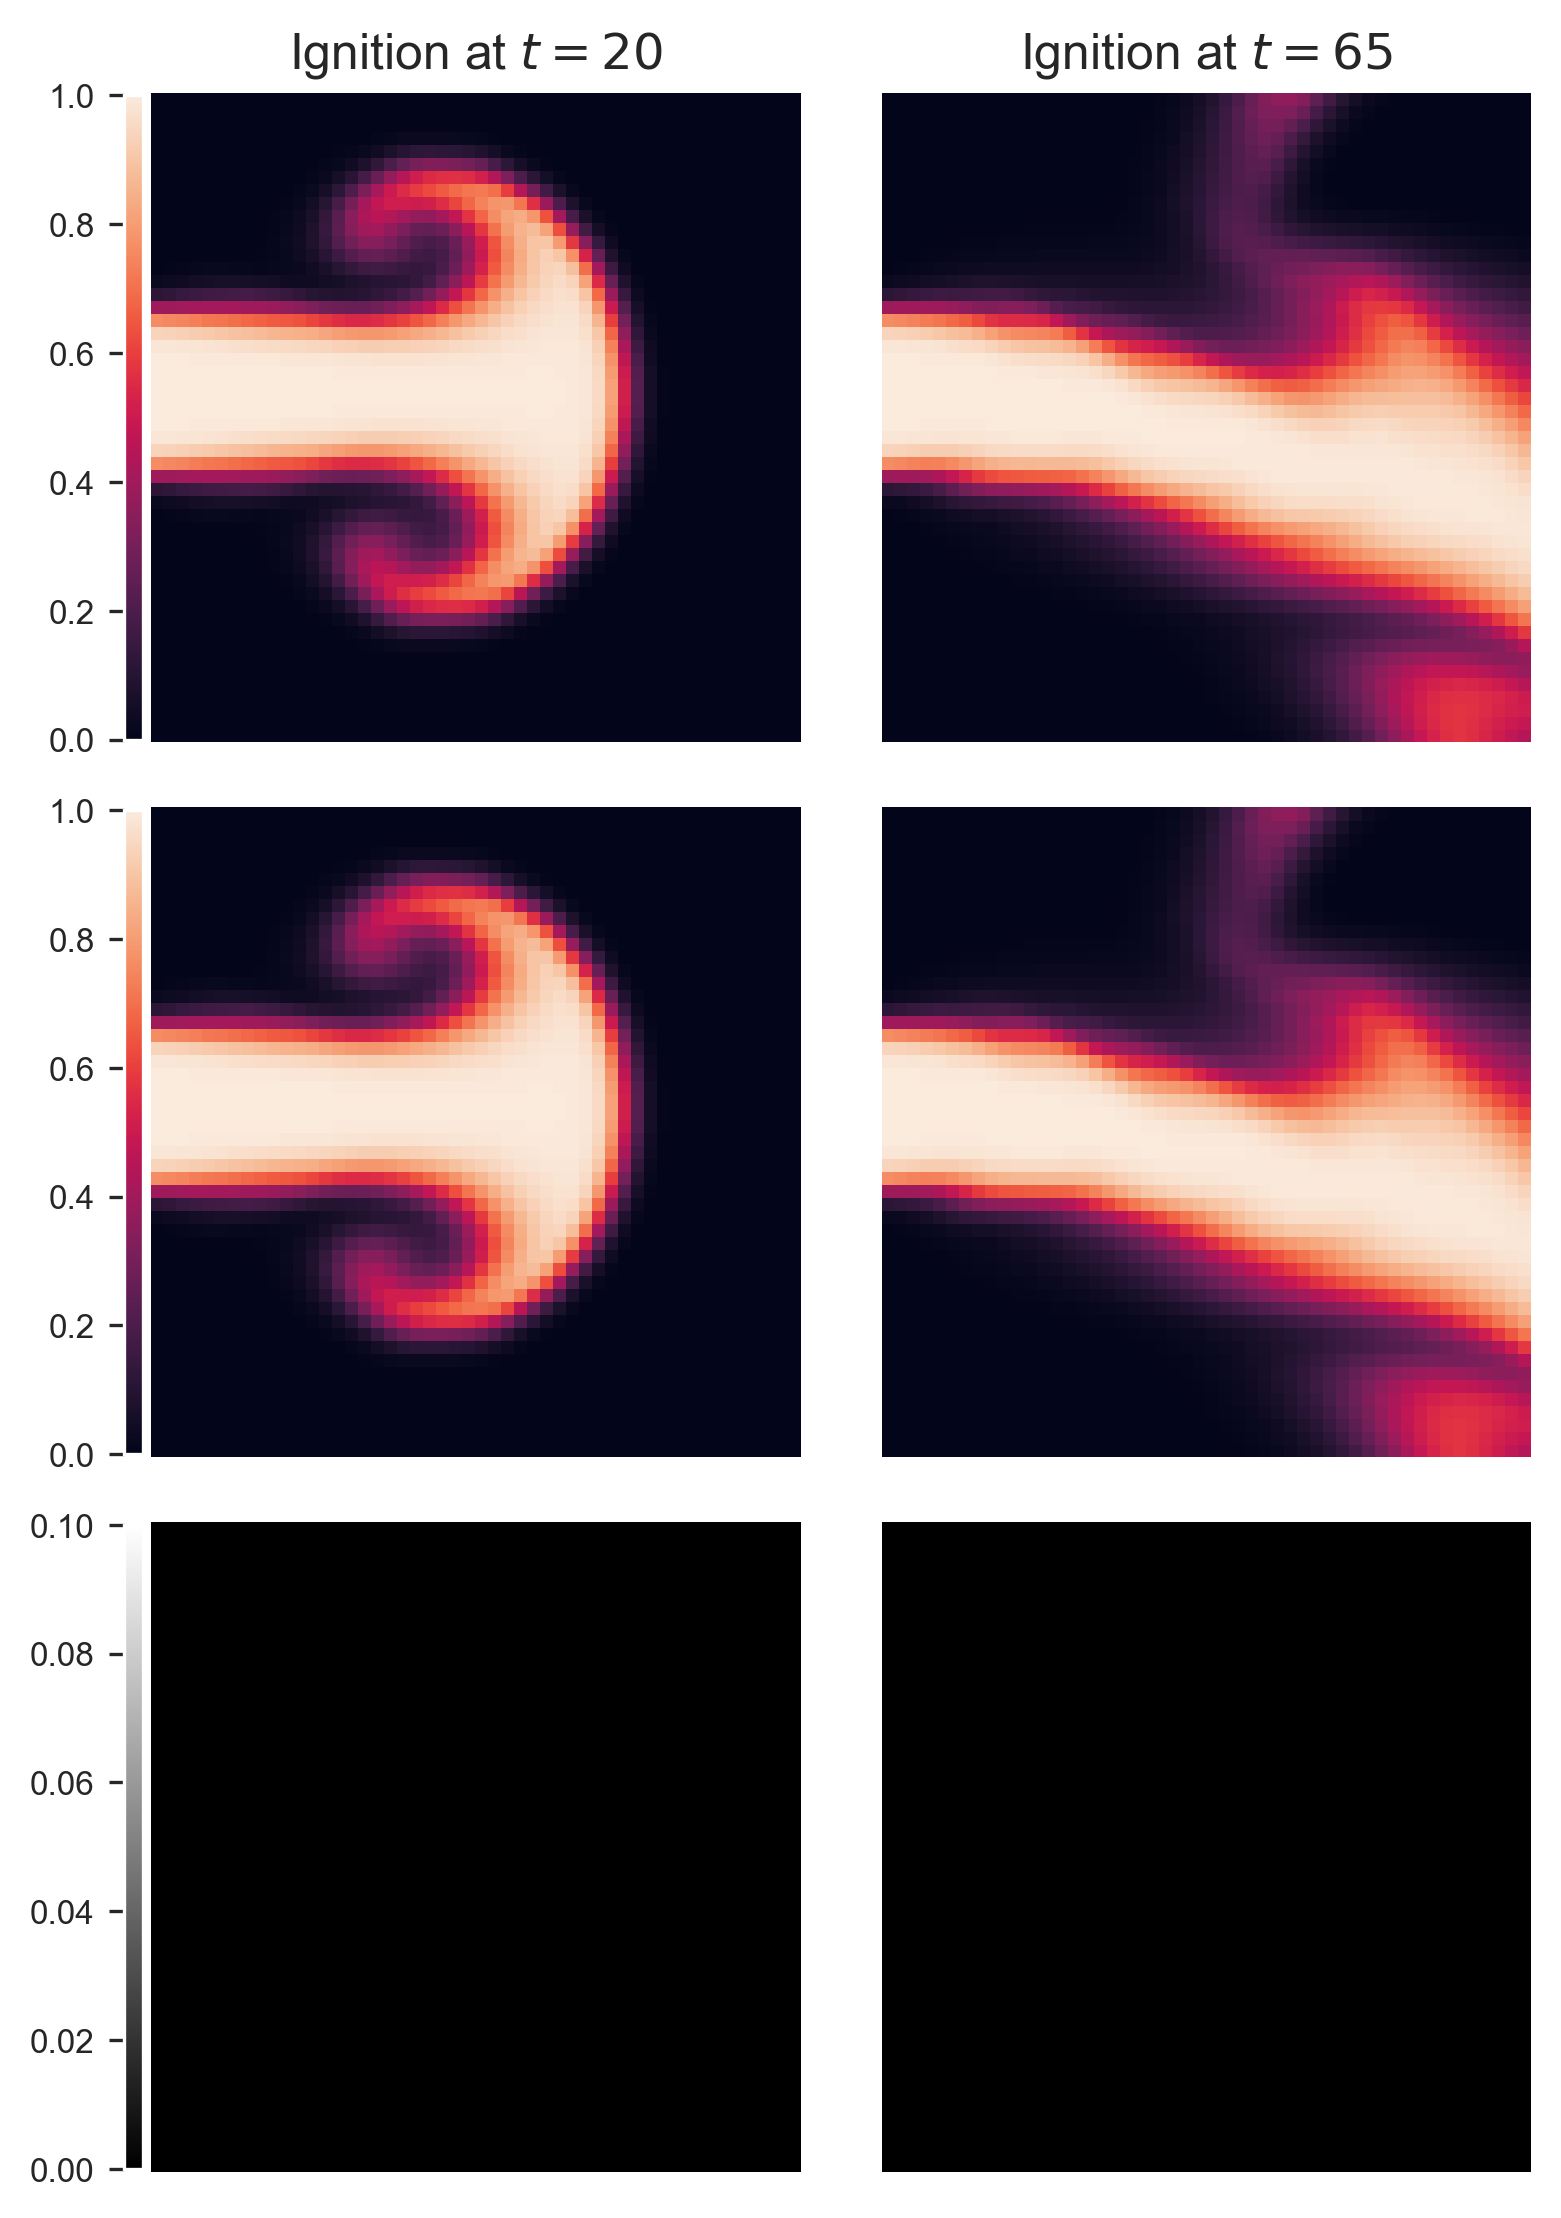

In [107]:
time_steps = [20 , 65]

max_disp = np.max(dataset)
min_disp = np.min(dataset)

my_map = seaborn.color_palette(palette='rocket', as_cmap=True)

error_map = seaborn.color_palette(palette='gray', as_cmap=True)

max_disp = 1
min_disp = 0

x = np.linspace(0,1,50)
y = np.linspace(0,1,50)

grid = np.meshgrid(*(x,y))


fig = plt.figure(figsize=(6,9), dpi=300)

axs = [fig.add_subplot(3,2,i+1) for i in range(6)]


map_it0 = axs[0].pcolor(*grid,dataset[time_steps[0],:].reshape(50,50),  vmin=min_disp, vmax=max_disp, cmap=my_map)

map_it2 = axs[2].pcolor(*grid,processed_data[time_steps[0],:].reshape(50,50), vmin=min_disp, vmax=max_disp, cmap=my_map)

map_it4 = axs[4].pcolor(*grid, difference_norm[time_steps[0],:].reshape(50,50),  vmin=0, vmax=0.1, cmap=error_map)

axs[1].pcolor(*grid, dataset[time_steps[1],:].reshape(50,50),  vmin=min_disp, vmax=max_disp, cmap=my_map)

axs[3].pcolor(*grid, processed_data[time_steps[1],:].reshape(50,50), vmin=min_disp, vmax=max_disp, cmap=my_map)

axs[5].pcolor(*grid, difference_norm[time_steps[1],:].reshape(50,50), vmin=0, vmax=0.1, cmap=error_map)

# Tweak all the axes 
for ax in axs:
    #ax.label_outer()
    ax.set_aspect('equal')
    #ax.margins(x=0.01, y = 0.06)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    ax.set_axis_off()   

plt.subplots_adjust(hspace = 0.1, wspace = 0.1)

axs[1].set_axis_off()   
axs[3].set_axis_off()   
axs[5].set_axis_off()   

# Make colorbars 
bbox = axs[0].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0] - 0.015, pos[1] + 0.001 , pos[2]*0.03, pos[3] - 0.002])
plt.colorbar(map_it0, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

bbox = axs[2].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0]- 0.015, pos[1] + 0.001, pos[2]*0.03, pos[3] - 0.002])
plt.colorbar(map_it2, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

bbox = axs[4].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0] - 0.015, pos[1] + 0.001, pos[2]*0.03, pos[3] - 0.002])
plt.colorbar(map_it4, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)



axs[0].set_title(r'Ignition at $t=20$')

axs[1].set_title(r'Ignition at $t=65$')


axs[0].yaxis.set_label_coords(-0.25,0.5)
axs[0].set_ylabel('Original')
axs[2].yaxis.set_label_coords(-0.25,0.5)
axs[2].set_ylabel('Reconstructed')
axs[4].yaxis.set_label_coords(-0.25,0.5)
axs[4].set_ylabel('Error')


fig.savefig(save_path / f'pod_viz_results_{rank}.pdf', format='pdf', bbox_inches='tight', dpi=300)


In [6]:

def make_gif_single(dataset, locations, save_path):

    #gif frame closure
    @gif.frame
    def plot(i,j):
        plot_data_single(dataset[i,j,:], locations)


    #build frames
    for j in range(dataset.shape[1]):
        frames = [plot(i,j) for i in range(dataset.shape[0])]

        this_save = save_path / f'siam_cse_orig_neg1_invis_channel_{j}.gif'

        #save gif
        gif.save(frames, str(this_save), duration=50)

    return


def plot_data_single(dataset, locations):

    max_disp = torch.max(dataset)
    min_disp = torch.min(dataset)

    max_disp = 1
    min_disp = -1

    my_map = seaborn.color_palette(palette='rocket', as_cmap=True)

    #fig = plt.figure(figsize=(3,3), dpi=300)

    #axs = [fig.add_subplot(1,1,i+1) for i in range(1)]

    fig,axs = plt.subplots(1,1, figsize=(3,3), dpi=300, facecolor="None")

    max_x = torch.max(locations[:,0])
    max_y = torch.max(locations[:,1])

    flow_tri = triang(locations[:,0], locations[:,1])

    map_it0 = axs.tripcolor(flow_tri, dataset, facecolors=None, shading='gouraud', vmin=min_disp, vmax=max_disp, cmap= my_map)

    # Tweak all the axes 
    axs.label_outer()
    axs.set_aspect('equal')
    axs.margins(x=0.04, y = 0.04)
    axs.spines['top'].set_color('none')
    axs.spines['bottom'].set_color('none')
    axs.spines['left'].set_color('none')
    axs.spines['right'].set_color('none')
    axs.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    #ax.set_axis_off()   

    plt.subplots_adjust(hspace = 0.001, wspace = 0.001) 

    # Make colorbars 
    #bbox = axs.get_position()
    #pos = bbox.bounds
    #ax_cb = fig.add_axes([pos[0] -0.00, pos[1] + 0.0125 , pos[2]*0.03, pos[3] - 0.025])
    #plt.colorbar(map_it0, cax=ax_cb)
    #ax_cb.yaxis.set_ticks_position('left')
    #ax_cb.tick_params(labelsize = 8)

    #axs[0].yaxis.set_label_coords(-0.2,0.5)
    #axs[0].set_ylabel('Original')

In [24]:
make_gif_single(dataset, locations, save_path)

In [8]:
print(str((save_path / f'channel_{1}.gif')))

print(save_path)

this_save = save_path /  'channel_1.gif'

print(str(this_save))

C:\Users\Kevin\OneDrive - UCB-O365\Documents\Research\GitHub\CAE-Extensions\lightning_logs\ignition_mesh\qcae_mesh_pool\version_9\version_7\channel_1.gif
C:\Users\Kevin\OneDrive - UCB-O365\Documents\Research\GitHub\CAE-Extensions\lightning_logs\ignition_mesh\qcae_mesh_pool\version_9\version_7
C:\Users\Kevin\OneDrive - UCB-O365\Documents\Research\GitHub\CAE-Extensions\lightning_logs\ignition_mesh\qcae_mesh_pool\version_9\version_7\channel_1.gif


In [23]:

def make_gif_panel(dataset, processed_data, difference_norm, locations, save_path):

    #gif frame closure
    @gif.frame
    def plot(i,j):
        plot_data_panel(dataset[i,j,:], processed_data[i,j,:], difference_norm[i,j,:], locations)


    #build frames
    for j in range(dataset.shape[1]):
        frames = [plot(i,j) for i in range(dataset.shape[0])]

        this_save = save_path / f'siam_cse_neg1_channel_{j}.gif'

        #save gif
        gif.save(frames, str(this_save), duration=50)

    return


def plot_data_panel(dataset, processed_data, difference_norm, locations):

    max_disp = torch.max(dataset)
    min_disp = torch.min(dataset)

    max_disp = 1
    min_disp = 0

    my_map = seaborn.color_palette(palette='rocket', as_cmap=True)

    error_map = seaborn.color_palette(palette='gray', as_cmap=True)


    fig = plt.figure(figsize=(3,9), dpi=300)

    axs = [fig.add_subplot(3,1,i+1) for i in range(3)]

    max_x = torch.max(locations[:,0])
    max_y = torch.max(locations[:,1])

    flow_tri = triang(locations[:,0], locations[:,1])

    map_it0 = axs[0].tripcolor(flow_tri, dataset, facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

    map_it2 = axs[1].tripcolor(flow_tri, processed_data, facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

    map_it4 = axs[2].tripcolor(flow_tri, difference_norm, facecolors=None, shading='flat', vmin=0, vmax=0.1, cmap= error_map)

    # Tweak all the axes 
    for ax in axs:
        ax.label_outer()
        ax.set_aspect('equal')
        ax.margins(x=0.04, y = 0.04)
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
        #ax.set_axis_off()   

    plt.subplots_adjust(hspace = 0.001, wspace = 0.001) 

    # Make colorbars 
    bbox = axs[0].get_position()
    pos = bbox.bounds
    ax_cb = fig.add_axes([pos[0] -0.00, pos[1] + 0.0125 , pos[2]*0.03, pos[3] - 0.025])
    plt.colorbar(map_it0, cax=ax_cb)
    ax_cb.yaxis.set_ticks_position('left')
    ax_cb.tick_params(labelsize = 8)

    bbox = axs[1].get_position()
    pos = bbox.bounds
    ax_cb = fig.add_axes([pos[0]-0.000, pos[1] + 0.0125, pos[2]*0.03, pos[3] - 0.025])
    plt.colorbar(map_it2, cax=ax_cb)
    ax_cb.yaxis.set_ticks_position('left')
    ax_cb.tick_params(labelsize = 8)

    bbox = axs[2].get_position()
    pos = bbox.bounds
    ax_cb = fig.add_axes([pos[0]+0.00, pos[1] + 0.0125, pos[2]*0.03, pos[3] - 0.025])
    plt.colorbar(map_it4, cax=ax_cb)
    ax_cb.yaxis.set_ticks_position('left')
    ax_cb.tick_params(labelsize = 8)

    axs[0].yaxis.set_label_coords(-0.2,0.5)
    axs[0].set_ylabel('Original')
    axs[1].yaxis.set_label_coords(-0.2,0.5)
    axs[1].set_ylabel('Reconstructed')
    axs[2].yaxis.set_label_coords(-0.2,0.5)
    axs[2].set_ylabel('Error')

In [13]:
make_gif_panel(dataset, processed_data, difference_norm, locations, save_path)

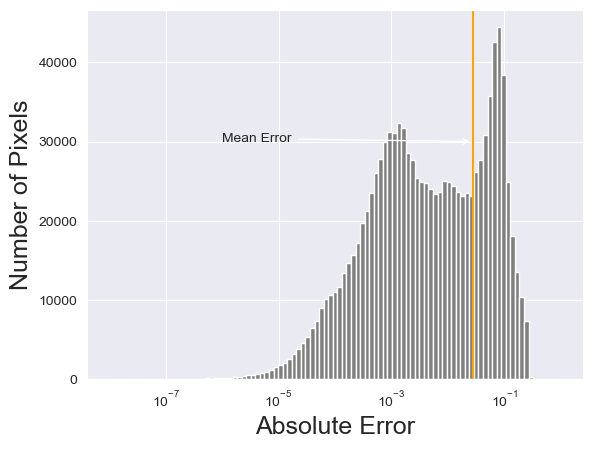

In [5]:

plt.hist(difference_norm.flatten(),bins=np.logspace(np.log10(1e-8),np.log10(1.0), 100), log=False, color='grey')
plt.gca().set_xscale("log")
plt.ylabel('Number of Pixels', fontsize=18)
plt.xlabel('Absolute Error', fontsize=18)

plt.axvline(x = torch.mean(difference_norm), color = 'orange', label = 'Mean Error')
plt.annotate('Mean Error' , (torch.mean(difference_norm),3e4), xytext=(1e-6, 3e4), textcoords='data', arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

plt.savefig(save_path / 'ignition_abs_error_histogram.pdf', format='pdf')


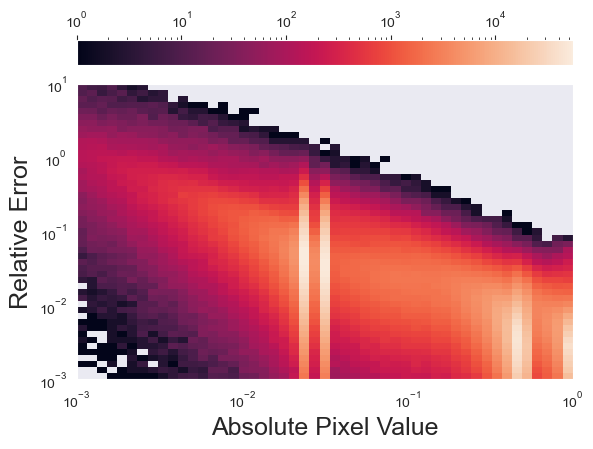

In [6]:
xbin = np.logspace(np.log10(1e-3),np.log10(1.), 50)
ybin = np.logspace(np.log10(1e-3),np.log10(10), 50)

plt.hist2d( torch.abs(dataset.flatten()).numpy(), relative_difference_norm.flatten().numpy(), bins=[xbin,ybin], norm = colors.LogNorm())

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.colorbar(location='top')
plt.xlabel('Absolute Pixel Value', fontsize=18)
plt.ylabel('Relative Error', fontsize=18)

plt.savefig(save_path / 'ignition_abs_rel_histogram.pdf', format='pdf')

<Figure size 640x480 with 0 Axes>

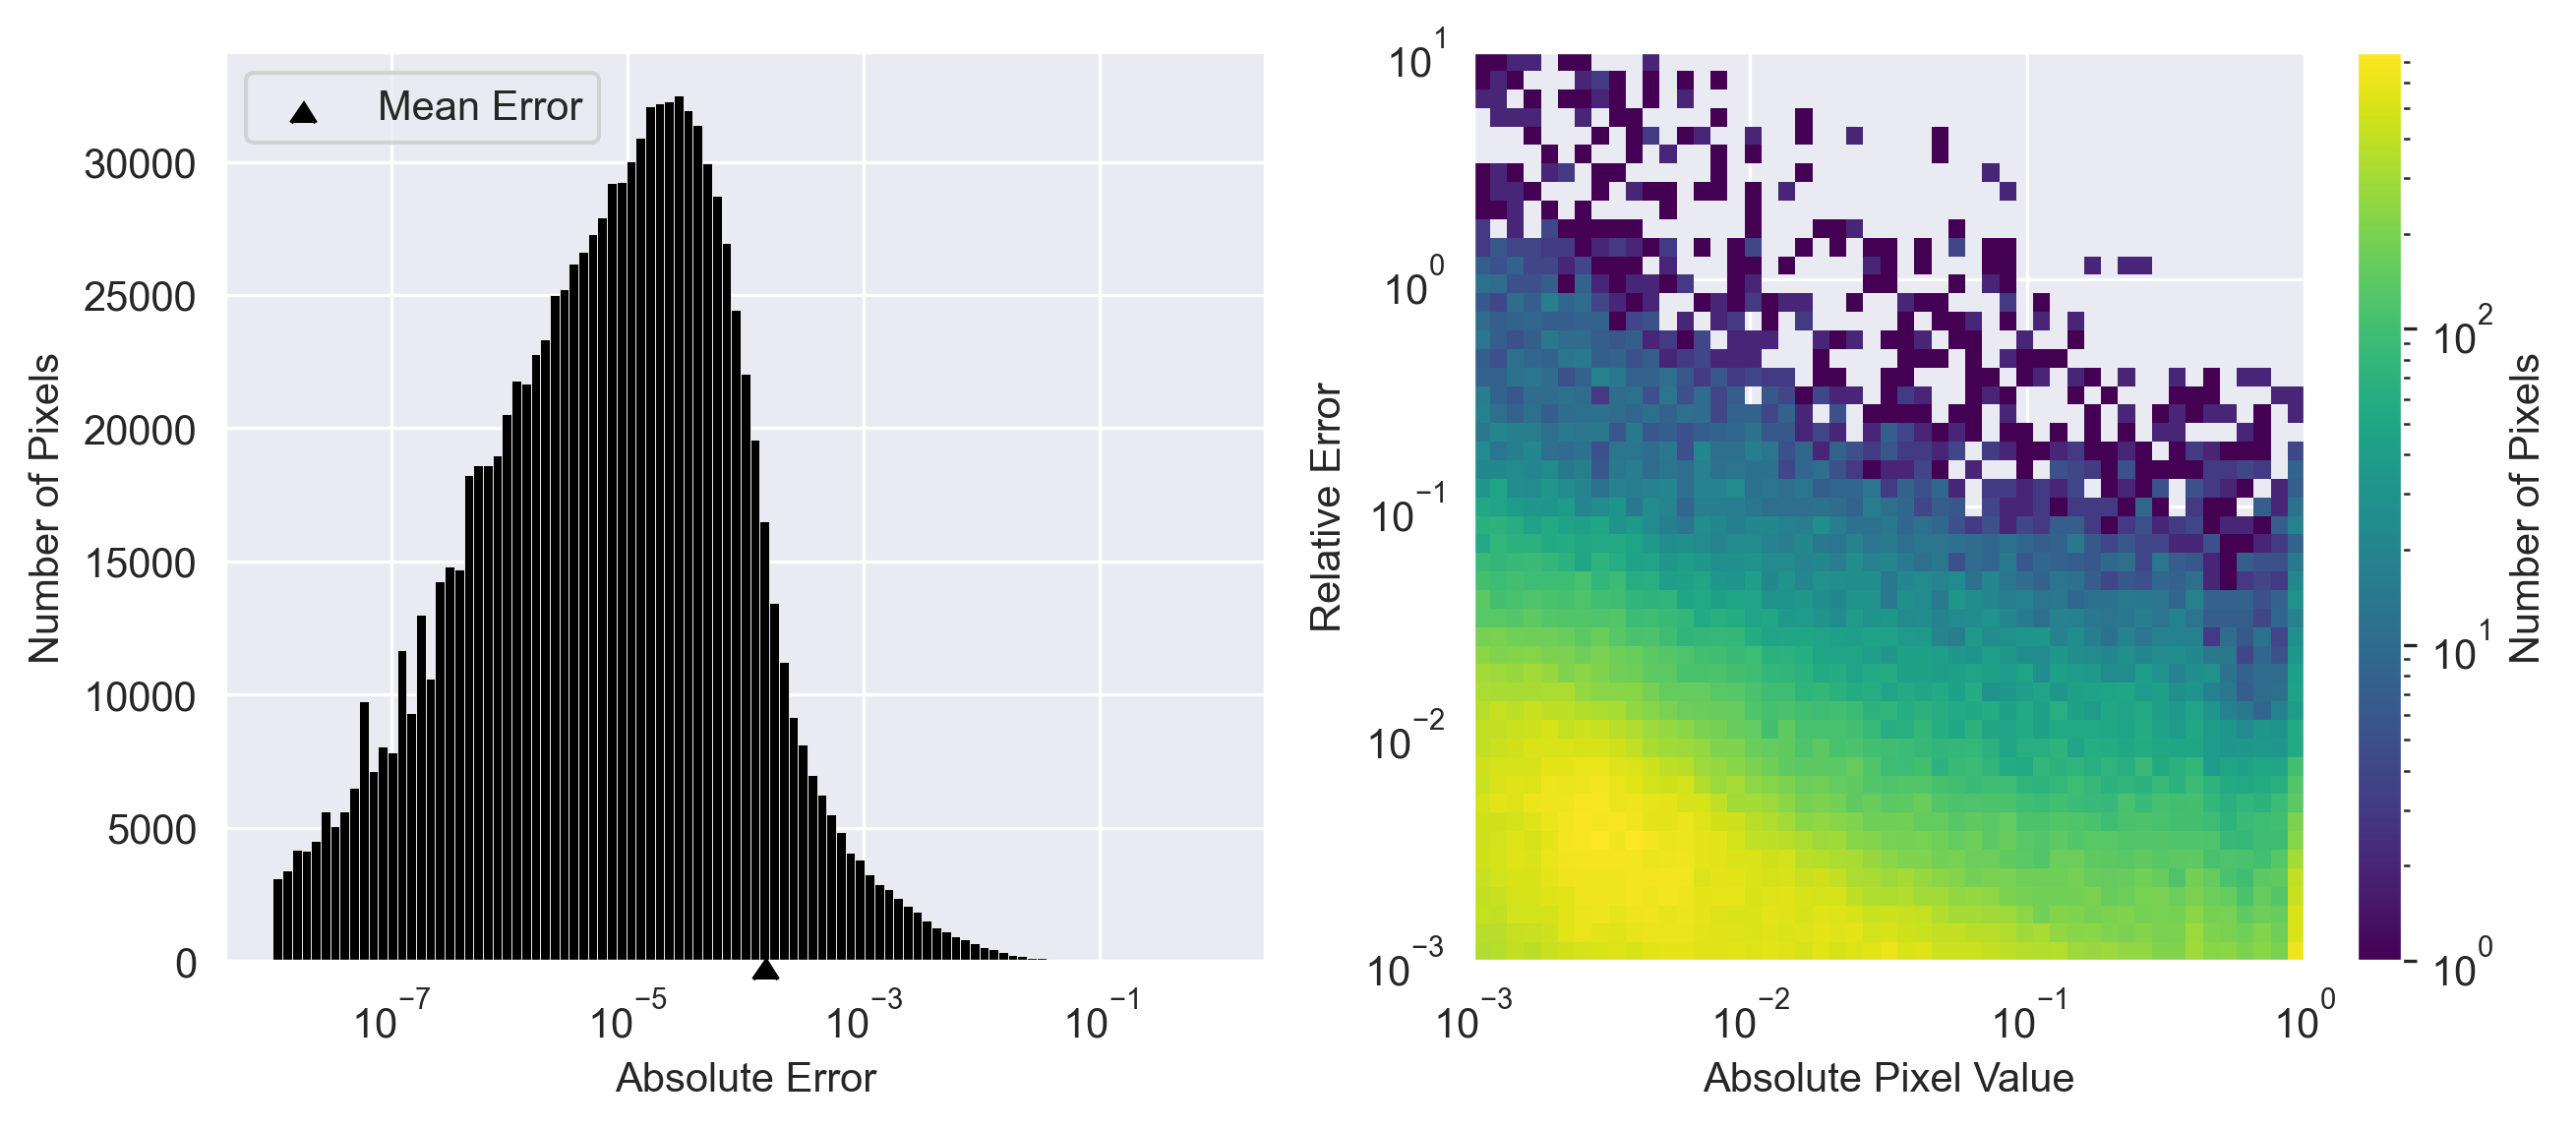

In [108]:
# subplot version of histograms

plt.subplots_adjust(hspace = 0.1, wspace = 0.01)

fig = plt.figure(figsize=(10,4), dpi=300)

haxs = [fig.add_subplot(1,2,i+1) for i in range(2)]

haxs[0].hist(difference_norm.flatten(),bins=np.logspace(np.log10(1e-8),np.log10(1.0), 100), log=False, color='black', linewidth=0.2)
haxs[0].set_xscale("log")
haxs[0].set(xlabel="Absolute Error",ylabel="Number of Pixels")

mean_mark = haxs[0].plot(np.mean(difference_norm), 0, color = 'black', marker=6,label = 'Mean Error', zorder=10, clip_on=False, linestyle="None")

haxs[0].legend(loc='upper left')

hist_map = seaborn.color_palette(palette='viridis', as_cmap=True)

xbin = np.logspace(np.log10(1e-3),np.log10(1.), 50)
ybin = np.logspace(np.log10(1e-3),np.log10(10), 50)

h2 = haxs[1].hist2d( np.abs(dataset.flatten()), relative_difference_norm.flatten(), bins=[xbin,ybin], norm = colors.LogNorm(), cmap=hist_map)

haxs[1].set_xscale("log")
haxs[1].set_yscale("log")
haxs[1].set(xlabel="Absolute Pixel Value",ylabel="Relative Error")

fig.colorbar(h2[3], ax=haxs[1], location='right', label = 'Number of Pixels')

plt.savefig(save_path / f'pod_error_analysis_{rank}.pdf', format='pdf', bbox_inches='tight', dpi=300)

In [109]:
# print relevant numbers


net_data = {}

#compute average relative reconstruction error
dim = (1)

n = np.sqrt(np.sum((dataset-processed_data)**2, axis=dim))
d = np.sqrt(np.sum((dataset)**2, axis=dim))

net_data['avg_relative_mse'] = np.mean(n/d)
net_data['max_relative_mse'] = np.max(n/d)
#net_data['param_count'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
net_data['data_shape'] = dataset.shape
net_data['avg_mse'] = np.mean(n)

info_filename = f'network_details_{rank}.txt'

info_file = save_path / info_filename

with open(info_file, "w") as file:
    for key, value in net_data.items():
        file.write(f"{key}: {value}\n")
        print(f'{key}: {value}\n')

avg_relative_mse: 0.0009617795003578067

max_relative_mse: 0.1227312833070755

data_shape: (450, 2500)

avg_mse: 0.015770498663187027

